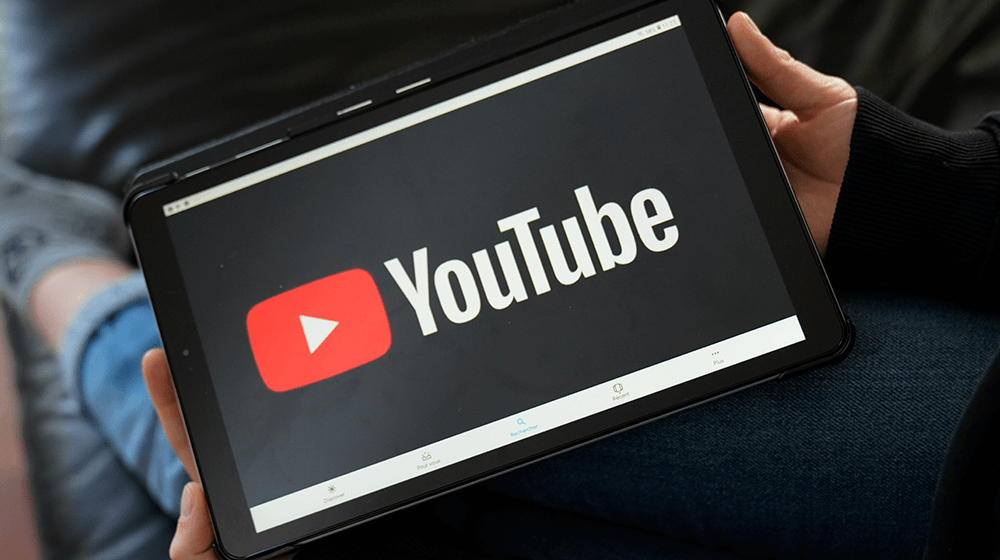

<h1 align='center'> Do Categories Matter? </h1>

YouTube is a global online platform for sharing, creating, and commenting on video.  According to Statista.com, YouTube has over 2.5 billion active monthly users.  Out of the billions of hours of content, YouTube maintains a list of Top Trending Videos that gets updated every 15 minutes.

Out of all that factors that can make a video trend, does the category of interest a video covers matter?  For example, do videos about the news trend as much as those about sports?  Do videos in different categories have a similar level of engagement by YouTube's audience?

Let's attempt to answer these questions using a kaggle [dataset by Mitchell J](https://www.kaggle.com/datasets/datasnaek/youtube-new) that contain several months of data on daily trending YouTube videos.  I will use the english speaking countries:  United States, Canada, and Great Britian.

**Null Hypothesis** :  Videos from different categories trend and are engaged with equally. In numerical terms, this translates to close to the average with little variation.

**Alternate Hypothesis** :  Videos from some categories trend and are engaged with disproportionately (large variations from the mean).

## Import Modules And Read-in Data

In [4]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from scipy.stats import chisquare

us_data = pd.read_csv('data/USvideos.csv')
ca_data = pd.read_csv('data/CAvideos.csv')
gb_data = pd.read_csv('data/GBvideos.csv')

us_data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


Data for Canada and Great Britian is laid out exactly as the United States data is above.  More information on the columns and missing values is below:

In [5]:
print('Additional information on US data:\n')
print(us_data.info())

print('\n\n\nAdditional information on Canada data:\n')
print(ca_data.info())

print('\n\n\nAdditional information on Great Britian data:\n')
print(gb_data.info())

Additional information on US data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_rem

We only have missing data in the description column.  Fortunately, we will not use this column.  Next, we will start with data transformation.

## Functions

In [1]:
def create_cat_dict(json_file):
    '''
    Uses json file to create a category dictionary with `category_id` as the key
    and category name as the value.
    
    Args:
        json_file (str):  Either json file name or path. 
        
    Returns:
        dict
    '''
    
    with open(json_file) as json_data:
        python_dict = json.load(json_data)
        video_metadata_list = python_dict['items']
        json_data.close()

    cat_dict = {}
    for i in range(len(video_metadata_list)):
        cat_key = int(video_metadata_list[i]['id'])
        cat_item = video_metadata_list[i]['snippet']['title']
        cat_dict[cat_key] = cat_item
    
    return cat_dict




def create_engage_chart(data, title):
    '''
    Will create a horizontal bar graph of interactions
    by category
    
    Args:
        data (DataFrame): video data
        
        title (str): name of the chart
    '''
    
    mask = data['comments_disabled'] == False
    comments_enabled = data[mask].copy()

    comments_enabled['engagement'] = comments_enabled[['views', 'likes', 'dislikes', 'comment_count']].sum(axis=1)
    engage_series = comments_enabled.groupby('category')['engagement'].sum().sort_values()

    fig, ax = plt.subplots(figsize=(12,8))
    ax.barh(engage_series.index, engage_series.values)
    ax.set_title(title)
    ax.set_xticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40'])
    ax.set_xlabel('numbers in billions')
    plt.show()  
    
    
    
    
def chisq_test(data):
    '''
    Will perform the chisquare test and return the probability, as a percentage,
    that observed values are by chance.
    
    Args:
        data (DataFrame):  Country data. 
        
    Returns:
        float
    '''
    
    cat_num = len(data['category'].unique())
    observed = data['category'].value_counts().values
    expected = [data['category'].value_counts().mean()] * cat_num
    chisq, pvalue = chisquare(observed, expected)
    
    return pvalue * 100

## Get Categories From Json Files And Add To Data

In the three dataframes we created at in the beginning, there is a column `category_id` that map to category names in separate json files.  Let's create a `category` column with a category name for each video.

In [7]:
us_cat_dict = create_cat_dict('data/US_category_id.json')

ca_cat_dict = create_cat_dict('data/CA_category_id.json')    
ca_cat_dict[29] = us_cat_dict[29]  # Missing this category_id.  Add to avoid KeyError when creating `category` column.

gb_cat_dict = create_cat_dict('data/GB_category_id.json')
gb_cat_dict[29] = us_cat_dict[29]  # Missing this category_id.  Add to avoid KeyError when creating `category` column.  


us_data['category'] = us_data['category_id'].apply(lambda x: us_cat_dict[x])
ca_data['category'] = ca_data['category_id'].apply(lambda x: ca_cat_dict[x])
gb_data['category'] = gb_data['category_id'].apply(lambda x: gb_cat_dict[x])

## How Many Trending Videos Are In Each Category?

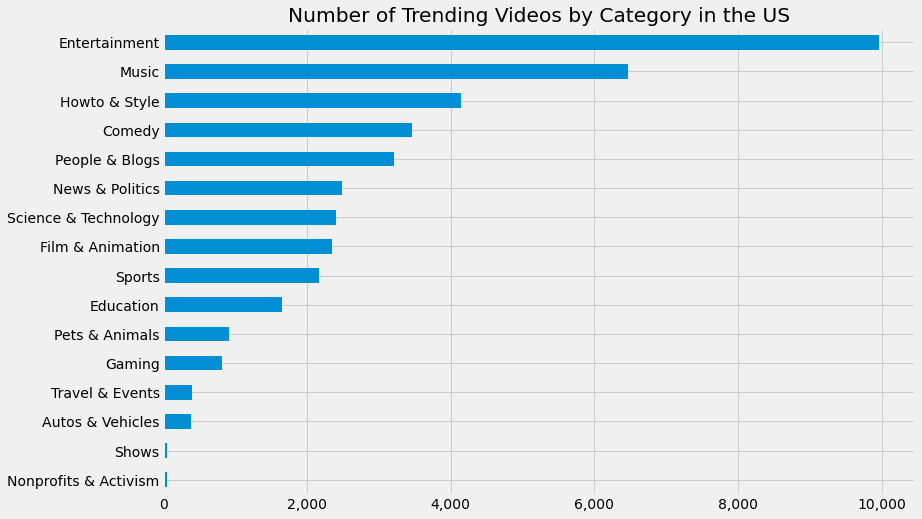

In [8]:
plt.style.use('fivethirtyeight')
us_data['category'].value_counts(ascending=True).plot.barh(figsize=(12,8), 
                                                           title='Number of Trending Videos by Category in the US',)
plt.xticks(ticks=[0, 2000, 4000, 6000, 8000, 10000], labels=['0', '2,000', '4,000', '6,000', '8,000', '10,000'])
plt.show()

Video count per category varies by approximately 2,615 videos around the mean.

In [9]:
us_data['category'].value_counts().describe()

count      16.000000
mean     2559.312500
std      2614.805429
min        57.000000
25%       713.250000
50%      2259.500000
75%      3271.750000
max      9964.000000
Name: category, dtype: float64

Below is the data from the chart by percentage:

In [17]:
us_data['category'].value_counts(normalize=True) * 100

Entertainment            24.332707
Music                    15.805026
Howto & Style            10.124789
Comedy                    8.442209
People & Blogs            7.839019
News & Politics           6.073408
Science & Technology      5.863391
Film & Animation          5.726636
Sports                    5.309043
Education                 4.044055
Pets & Animals            2.246697
Gaming                    1.995165
Travel & Events           0.981709
Autos & Vehicles          0.937752
Shows                     0.139198
Nonprofits & Activism     0.139198
Name: category, dtype: float64

Approximately, fifty percent of trending videos fall in the top three categories.

## What is the likelyhood that this difference is by chance?

The observed data is above; and the expected data, assuming categories do not matter, would be an average of all videos.  Below, we will use the Chi-squared Test to get a p-value that will tell us what is the probability that the distribution above is by chance.

In [22]:
cat_pvalue = chisq_test(us_data)
print(f"It's a {cat_pvalue}% chance.  Now, let's take a look at Canada and Great Britian.")

It's a 0.0% chance.  Now, let's take a look at Canada and Great Britian.


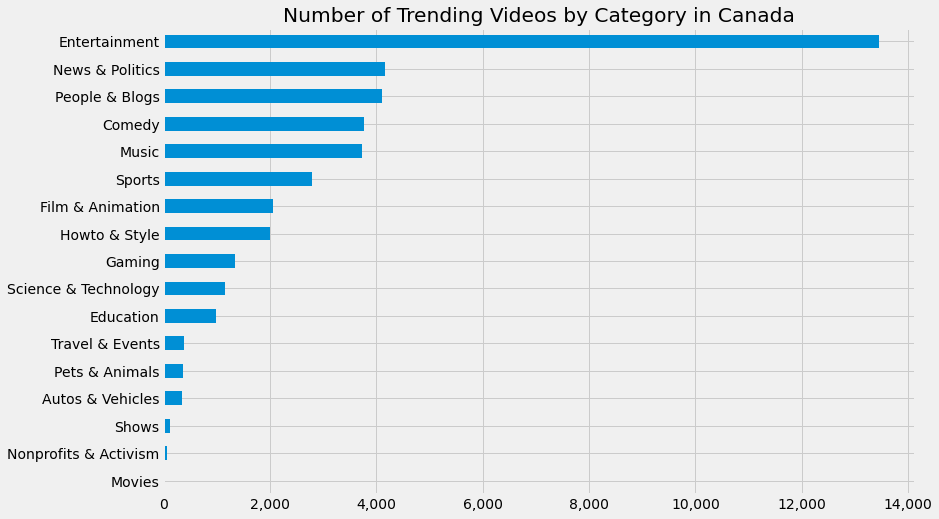

In [39]:
ca_data['category'].value_counts(ascending=True).plot.barh(figsize=(12,8), title='Number of Trending Videos by Category in Canada')
plt.xticks(ticks=[0, 2000, 4000, 6000, 8000, 10000, 12000, 14000], labels=['0', '2,000', '4,000', '6,000', '8,000', '10,000', '12,000', '14,000'])
plt.show()

Video count per category varies by approximately 3,216 videos around the mean.

In [48]:
ca_data['category'].value_counts().describe()

count       17.000000
mean      2404.764706
std       3216.375999
min          6.000000
25%        369.000000
50%       1344.000000
75%       3731.000000
max      13451.000000
Name: category, dtype: float64

Below is the data from the chart by percentage:

In [140]:
ca_data['category'].value_counts(normalize=True) * 100

Entertainment            32.902815
News & Politics          10.173430
People & Blogs           10.041339
Comedy                    9.229226
Music                     9.126489
Sports                    6.817348
Film & Animation          5.039016
Howto & Style             4.909371
Gaming                    3.287591
Science & Technology      2.825273
Education                 2.424109
Travel & Events           0.958881
Pets & Animals            0.902620
Autos & Vehicles          0.863482
Shows                     0.303319
Nonprofits & Activism     0.181013
Movies                    0.014677
Name: category, dtype: float64

#### by chance?

In [40]:
cat_pvalue = chisq_test(ca_data)
print(f"It's a {cat_pvalue}% chance this distibution is random.  Now, let's take a look at Great Britian.")

It's a 0.0% chance this distibution is random.  Now, let's take a look at Great Britian.


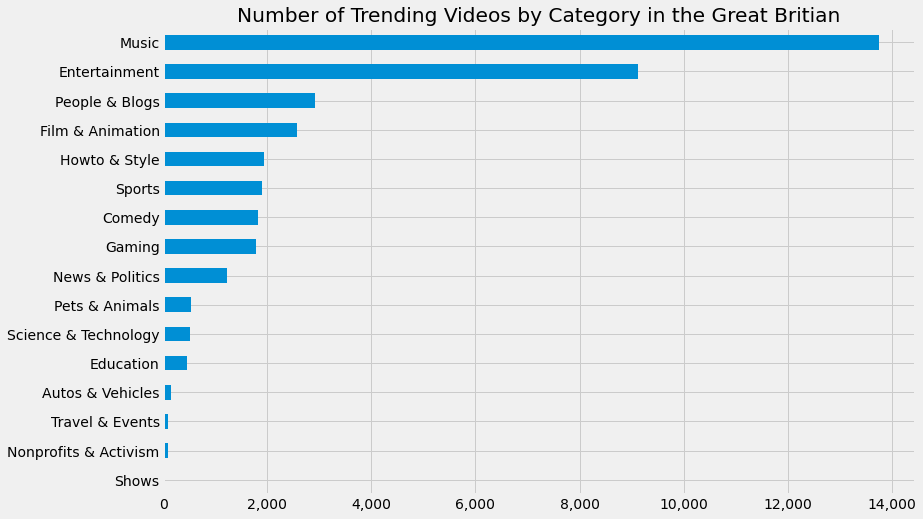

In [37]:
gb_data['category'].value_counts(ascending=True).plot.barh(figsize=(12,8), title='Number of Trending Videos by Category in the Great Britian')
plt.xticks(ticks=[0, 2000, 4000, 6000, 8000, 10000, 12000, 14000], labels=['0', '2,000', '4,000', '6,000', '8,000', '10,000', '12,000', '14,000'])
plt.show()

Video count per category varies by approximately 3,734 videos around the mean.

In [49]:
gb_data['category'].value_counts().describe()

count       16.000000
mean      2432.250000
std       3734.189988
min         20.000000
25%        378.750000
50%       1506.500000
75%       2090.250000
max      13754.000000
Name: category, dtype: float64

Below is the data from the chart by percentage:

In [143]:
gb_data['category'].value_counts(normalize=True) * 100

Music                    35.342790
Entertainment            23.445370
People & Blogs            7.518758
Film & Animation          6.621955
Howto & Style             4.954260
Sports                    4.900298
Comedy                    4.697297
Gaming                    4.594511
News & Politics           3.147806
Pets & Animals            1.372186
Science & Technology      1.331072
Education                 1.174324
Autos & Vehicles          0.370028
Travel & Events           0.246685
Nonprofits & Activism     0.231267
Shows                     0.051393
Name: category, dtype: float64

#### by chance?

In [41]:
cat_pvalue = chisq_test(gb_data)
print(f"It's a {cat_pvalue}% chance this distribution is random.")

It's a 0.0% chance this distribution is random.


## Now, how much "engagement" is there with videos in each category?

To answer this question, I will create a column, `engagement`.  It will be the sum of views, likes, dislikes, and comment_count.
- To ensure our `comment_count` column is an accurate member of engagement, I'll delete rows that have `comments_disabled` turned on; this represents less than 2% of the data,
- create `engagement` column,
- and group by categories and graph.

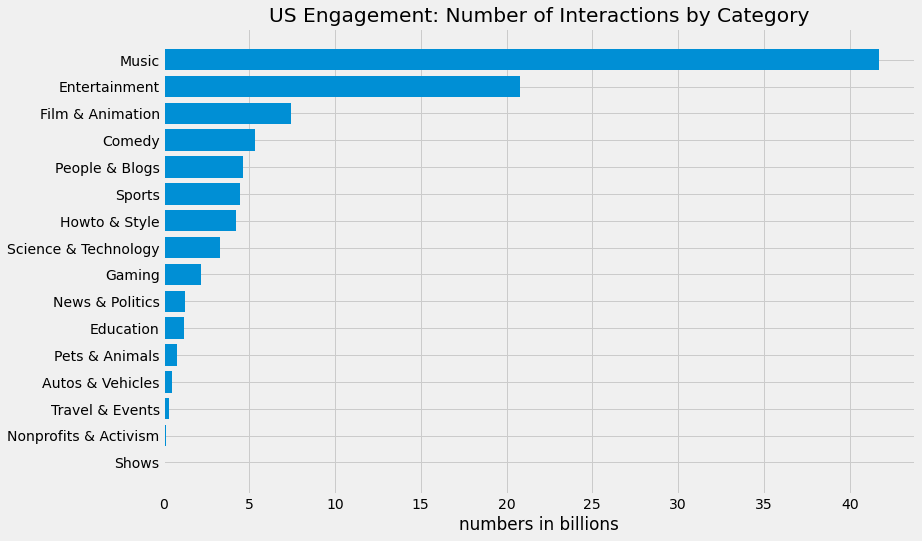

In [145]:
create_engage_chart(us_data, 'US Engagement: Number of Interactions by Category')

Same data as above by percentage:

In [146]:
cat_engagement = us_comments_enabled.groupby('category')['engagement'].sum()
cat_engagement_pct = (cat_engagement / cat_engagement.sum() * 100).sort_values(ascending=False)
cat_engagement_pct

category
Music                    42.292972
Entertainment            21.054606
Film & Animation          7.556114
Comedy                    5.439635
People & Blogs            4.698307
Sports                    4.540082
Howto & Style             4.320653
Science & Technology      3.353920
Gaming                    2.260508
News & Politics           1.295414
Education                 1.254136
Pets & Animals            0.797644
Autos & Vehicles          0.533363
Travel & Events           0.354606
Nonprofits & Activism     0.194591
Shows                     0.053451
Name: engagement, dtype: float64

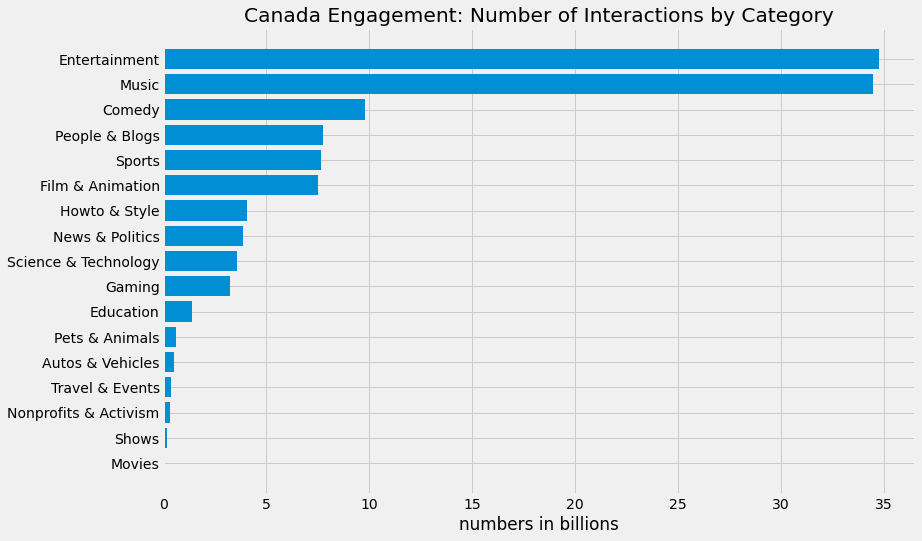

In [147]:
create_engage_chart(ca_data, 'Canada Engagement: Number of Interactions by Category')

Same data as above by percentage:

In [148]:
ca_cat_engagement = ca_comments_enabled.groupby('category')['engagement'].sum()
ca_cat_engagement_pct = (ca_cat_engagement / ca_cat_engagement.sum() * 100).sort_values(ascending=False)
ca_cat_engagement_pct

category
Entertainment            28.934140
Music                    28.699968
Comedy                    8.168067
People & Blogs            6.439747
Sports                    6.357964
Film & Animation          6.254771
Howto & Style             3.387422
News & Politics           3.208649
Science & Technology      2.973548
Gaming                    2.712088
Education                 1.158176
Pets & Animals            0.512885
Autos & Vehicles          0.424434
Travel & Events           0.308274
Nonprofits & Activism     0.273103
Shows                     0.150550
Movies                    0.036213
Name: engagement, dtype: float64

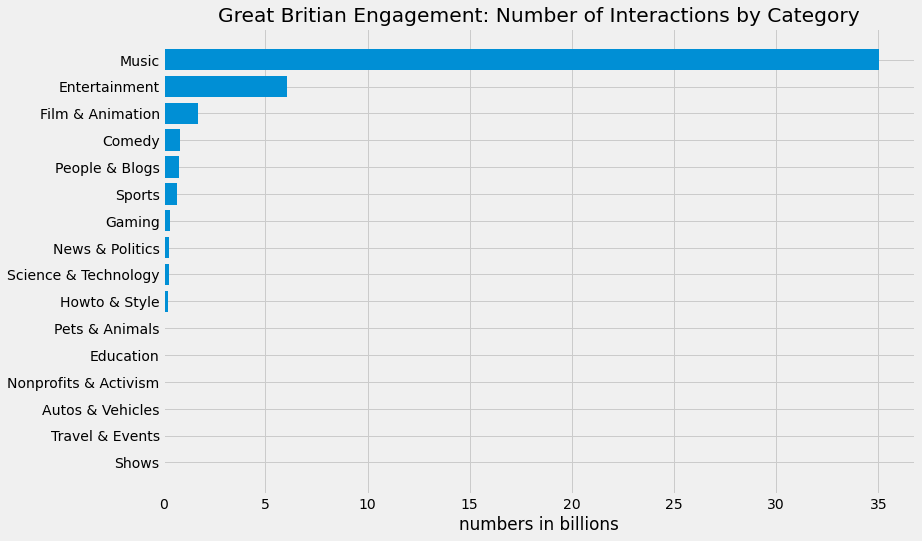

In [149]:
create_engage_chart(gb_data, 'Great Britian Engagement: Number of Interactions by Category')

Same data as above by percentage:

In [150]:
gb_cat_engagement = gb_comments_enabled.groupby('category')['engagement'].sum()
gb_cat_engagement_pct = (gb_cat_engagement / gb_cat_engagement.sum() * 100).sort_values(ascending=False)
gb_cat_engagement_pct

category
Music                    75.298617
Entertainment            12.991453
Film & Animation          3.612828
Comedy                    1.773844
People & Blogs            1.612940
Sports                    1.413942
Gaming                    0.755595
News & Politics           0.619947
Science & Technology      0.617998
Howto & Style             0.537502
Pets & Animals            0.240012
Education                 0.199243
Nonprofits & Activism     0.167791
Autos & Vehicles          0.088063
Travel & Events           0.057541
Shows                     0.012683
Name: engagement, dtype: float64

## Summary

After looking at over 120,000 trending videos in 3 countries, we can reject the null hypothesis and agree that categories matter in terms of what types of videos are trending and, even more so with, what type of videos are being engaged with.  All of our graphs are skewed; and using the chisquare test, we can safely conclude this is not by chance.  